# Flame Speed with Sensitivity Analysis

In this example we simulate a freely-propagating 1-D flame and
* Calculate its laminar burning velocity
* Perform a sensitivity analysis of its kinetics

![Freely Propagating Flame](images/flameSpeed.png)

### Import Modules

In [1]:
from __future__ import print_function
from __future__ import division

import cantera as ct
import numpy as np

print("Running Cantera Version: " + str(ct.__version__))

Running Cantera Version: 2.3.0a3


### Define some useful functions

In [2]:
def computeFlameSpeed(gas,\
                      f, tol_ss=[1.0e-9, 1.0e-14], tol_ts=[1.0e-5, 1.0e-14],\
                      ratio=3, slope=0.05, curve=0.1,\
                      jac_age=[10, 10],\
                      time_step=[1e-5, [2, 5, 10, 20, 30]],\
                      loglevel=0,\
                      transport_model='Mix'):

    """
    gas is a cantera.Solution object
    f is a cantera.FreeFlame object
    
    By default this computes the flame-speed using mixture-averaged transport
    """

    #Assign numerical knobs, etc
    f.flame.set_steady_tolerances(default=tol_ss)
    f.flame.set_transient_tolerances(default=tol_ts)
    f.set_refine_criteria(ratio, slope, curve)
    f.set_max_jac_age(jac_age[0], jac_age[1])
    f.set_time_step(time_step[0], time_step[1])

    #Model details
    f.energy_enabled = True

    try:
        if transport_model=='Mix':
            f.solve(loglevel=loglevel, refine_grid=True)
            
        elif transport_model=='Multi':
            f.transport_model = 'Mix'
            f.solve(loglevel=loglevel, refine_grid=True)
            f.transport_model = 'Multi'
            f.solve(loglevel=loglevel, refine_grid=True)
        
        return f.u[0]
    except:
        return np.NaN
        pass

### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [3]:
#Inlet Temperature in Kelvin and Inlet Pressure in Pascals
#In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

#Define the gas-mixutre and kinetics
#In this case, we are choosing a GRI3.0 gas
gas = ct.Solution('gri30.cti')

# Create a stoichiometric CH4/Air premixed mixture 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

### Define flame simulation conditions

In [4]:
#Domain width in metres
width = 0.014

#Create the flame object
flame = ct.FreeFlame(gas, width=width)

### Solve

In [5]:
returnValue = computeFlameSpeed(gas, flame)
Su0 = returnValue
print("Flame Speed is: {:.2f} cm/s".format(Su0*100))

#Note that the variable Su0 will also be used downsteam in the sensitivity analysis

Flame Speed is: 37.74 cm/s


### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see

In [6]:
# Import plotting modules and define plotting preference
import pylab as plt
%matplotlib notebook

plt.rcParams['figure.autolayout'] = True

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (8,6)

#### Temperature Plot

<IPython.core.display.Javascript object>


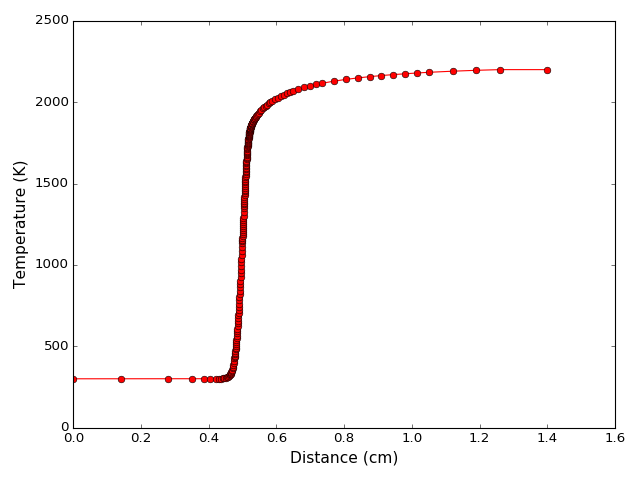

In [7]:
plt.figure()

plt.plot(flame.grid*100, flame.T, 'r-o')
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (K)');

#### Major species' plot

<IPython.core.display.Javascript object>


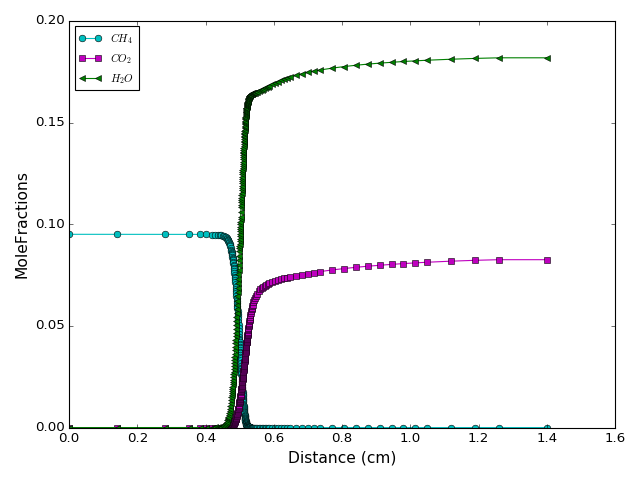

In [8]:
"""
# To plot species, we first have to identify the index of the species in the array
# For this, cut & paste the following lines and run in a new cell to get the index
for i, specie in enumerate(gas.species()):
    print(str(i) + '. ' + str(specie))
"""

# Extract concentration data
X_CH4 = flame.X[13]
X_CO2 = flame.X[15]
X_H2O = flame.X[5]

plt.figure()

plt.plot(flame.grid*100, X_CH4, 'c-o', label=r'$CH_{4}$')
plt.plot(flame.grid*100, X_CO2, 'm-s', label=r'$CO_{2}$')
plt.plot(flame.grid*100, X_H2O, 'g-<', label=r'$H_{2}O$')

plt.legend(loc=2)
plt.xlabel('Distance (cm)')
plt.ylabel('MoleFractions');

## Sensitivity Analysis

See which reactions effect the flame speed the most

### Import a data frame module. This simplifies the code

In [9]:
import pandas as pd

In [10]:
#Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(data=[], index=gas.reaction_equations(range(gas.n_reactions)))

### Compute sensitivities

In [11]:
#Set the value of the perturbation
sensitivities["baseCase"] = ""
dk = 1e-2

In [12]:
for m in range(gas.n_reactions):
    gas.set_multiplier(1.0) # reset all multipliers                                                                     
    gas.set_multiplier(1+dk, m) # perturb reaction m   
    #Always force loglevel=0 for this
    flame.solve(loglevel=0)
    Su = flame.u[0]
    
    sensitivities["baseCase"][m] = (Su-Su0)/(Su0*dk)

# This step is essential, otherwise the mechanism will have been altered
gas.set_multiplier(1.0)

In [13]:
sensitivities.head()

,baseCase
2 O + M <=> O2 + M,-0.000169409
H + O + M <=> OH + M,-0.000761633
H2 + O <=> H + OH,0.0290492
HO2 + O <=> O2 + OH,-0.00482413
H2O2 + O <=> HO2 + OH,-1.92426e-05


### Make plots

<IPython.core.display.Javascript object>


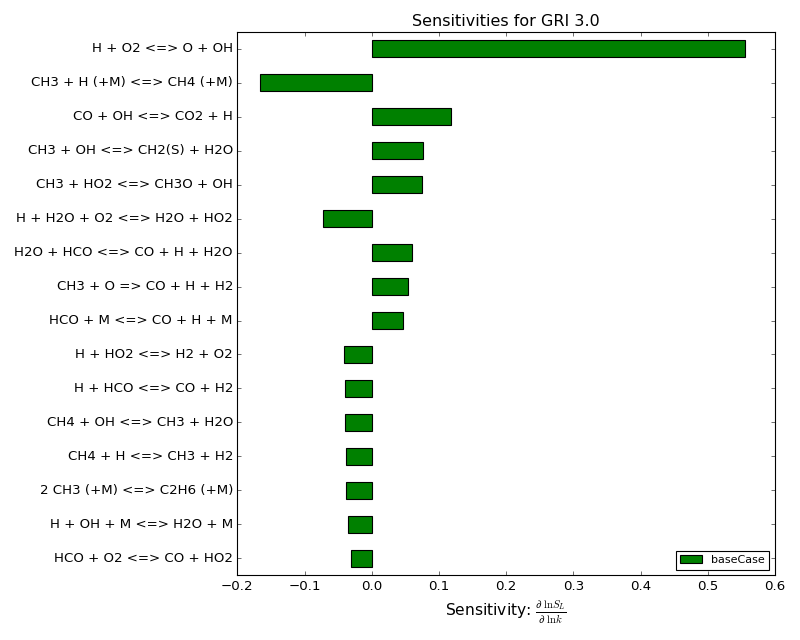

In [15]:
# Reaction mechanisms can contains thousands of elementary mechanisms. Choose a threshold
# to see only the top few
threshold = 0.03

firstColumn = sensitivities.columns[0]

# Collect only those steps to plot that meet the 
sensitivitiesSubset = sensitivities[sensitivities[firstColumn].abs() > threshold]
indicesMeetingThreshold = sensitivitiesSubset[firstColumn].abs().sort_values(ascending=False).index
sensitivitiesSubset.loc[indicesMeetingThreshold].plot.barh(figsize=(10,8),\
                                                          title="Sensitivities for GRI 3.0",
                                                          color='g')
plt.gca().invert_yaxis()

plt.xlabel(r'Sensitivity: $\frac{\partial\:\ln{S_{L}}}{\partial\:\ln{k}}$')
plt.legend(loc=4);

# Uncomment the following to save the plot. A higher than usual resolution (dpi) helps
# plt.savefig('sensitivityPlot', dpi=300)